[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# 映射-归约 (Map-reduce)

## 回顾 (Review)

我们正在构建一个多智能体研究助手，它将本课程中的所有模块结合起来。  

为了构建这个多智能体助手，我们一直在介绍一些 LangGraph 的可控性主题。  

我们刚刚学习了并行化 parallelization 和子图 sub-graphs。  

## 目标 (Goals)

现在，我们将学习 [映射-归约 (map reduce)](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)。

In [1]:
%%capture --no-stderr
## 让安装库时的大量下载信息不显示，但一旦出错，报错信息仍会显示出来
## 环境准备

## # 安装或升级所需的库
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

## 方便用户输入 API Key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
#_set_env("LANGSMITH_API_KEY")
#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 问题 (Problem)

映射-归约 (Map-reduce) 操作对于高效的任务分解和并行处理至关重要。  

它包含两个阶段：  

(1) `Map` —— 将一个任务拆分为更小的子任务，并行处理每个子任务。  

(2) `Reduce` —— 汇总所有已完成的并行子任务的结果。  

让我们设计一个系统来完成两件事：  

(1) `Map` —— 围绕某个主题生成一组笑话。  

(2) `Reduce` —— 从列表中挑选出最好的笑话。  

我们将使用大语言模型 (LLM) 来完成笑话的生成和选择工作。

In [3]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## 状态 (State)

### 并行化笑话生成 (Parallelizing joke generation)

首先，让我们定义图的入口点，它将会：  

* 接收用户输入的主题  
* 根据输入生成一个笑话主题列表  
* 将每个笑话主题发送到上面的笑话生成节点  

我们的状态包含一个 `jokes` 键，用来收集并行生成的笑话。


In [4]:
# 导入 Python 内置的 operator 模块，这里主要用到加法运算符 (operator.add)，用于列表追加
import operator

# 从 typing 模块导入 Annotated，用于给类型添加额外的元信息（例如指定 reducer）
from typing import Annotated

# 从 typing_extensions 导入 TypedDict，用于定义字典类型的结构
from typing_extensions import TypedDict

# 从 pydantic 导入 BaseModel，用于定义和验证数据模型
from pydantic import BaseModel


# 定义一个 Pydantic 模型：Subjects，表示笑话的子主题集合
class Subjects(BaseModel):
    subjects: list[str]   # 包含多个主题的字符串列表


# 定义一个 Pydantic 模型：BestJoke，表示最优笑话
class BestJoke(BaseModel):
    id: int   # 最优笑话的编号（整型）


# 定义整个系统的状态结构：OverallState
class OverallState(TypedDict):
    topic: str                                # 用户输入的主题
    subjects: list                            # 由主题拆分出的子主题列表
    jokes: Annotated[list, operator.add]      # 并行生成的笑话，使用 operator.add 进行结果累加
    best_selected_joke: str                   # 最终被选出的最佳笑话

给笑话生成主题。

In [5]:
def generate_topics(state: OverallState):
    # 根据用户输入的主题构建提示词
    prompt = subjects_prompt.format(topic=state["topic"])
    # 调用模型，并指定输出结构为 Subjects
    response = model.with_structured_output(Subjects).invoke(prompt)
    # 返回包含子主题的字典
    return {"subjects": response.subjects}

这里就是关键所在：我们使用 [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 来为每个子主题生成一个笑话。  

这非常有用！它可以自动并行地为任意数量的子主题生成笑话。  

* `generate_joke`：图中节点的名称  
* `{"subject": s}`：要发送的状态  

`Send` 允许你将任意状态传递给 `generate_joke`！它不必与 `OverallState` 完全一致。  

在这个例子中，`generate_joke` 使用它自己的内部状态，而我们可以通过 `Send` 来填充这个状态。

In [6]:
# 从 langgraph.types 导入 Send，用于向指定节点发送任务和状态
from langgraph.types import Send

# 定义函数：继续进入笑话生成阶段
def continue_to_jokes(state: OverallState):
    # 遍历 state 中的所有子主题 subjects，
    # 为每个子主题创建一个 Send 对象，发送到 "generate_joke" 节点，
    # 并传递 {"subject": s} 作为该节点的输入状态
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### 笑话生成 (map)

现在，我们只需要定义一个节点 `generate_joke` 来生成笑话！  

我们把生成的笑话写回到 `OverallState` 中的 `jokes` 键里。  

这个键有一个归约器 (reducer)，可以将多个列表合并起来。

In [7]:
# 定义笑话生成节点所需的输入状态结构
class JokeState(TypedDict):
    subject: str   # 输入的子主题（每个主题会单独生成一个笑话）

# 定义 Pydantic 模型，用于约束笑话的输出结构
class Joke(BaseModel):
    joke: str      # 模型输出的笑话文本

# 定义函数：根据子主题生成笑话
def generate_joke(state: JokeState):
    # 构造提示词，将当前子主题填入预定义的笑话 prompt 模板
    prompt = joke_prompt.format(subject=state["subject"])
    # 调用大语言模型，并指定输出结构为 Joke，确保输出符合 schema
    response = model.with_structured_output(Joke).invoke(prompt)
    # 返回一个字典，将生成的笑话放入列表，并写入 "jokes" 键
    return {"jokes": [response.joke]}


### 最佳笑话选择 (reduce)

现在，我们要添加逻辑来挑选出最好的笑话。

In [8]:
# 定义节点函数：选择最佳笑话 (reduce 阶段)
def best_joke(state: OverallState):
    # 将所有生成的笑话拼接成一个字符串，每条笑话之间用两个换行分隔
    jokes = "\n\n".join(state["jokes"])
    
    # 构造提示词，将主题和所有笑话放入预定义的最佳笑话选择模板
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    
    # 调用大语言模型，指定输出结构为 BestJoke（返回一个包含最佳笑话 id 的对象）
    response = model.with_structured_output(BestJoke).invoke(prompt)
    
    # 根据模型返回的 id，从 jokes 列表中取出对应的笑话，作为最佳笑话返回
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile

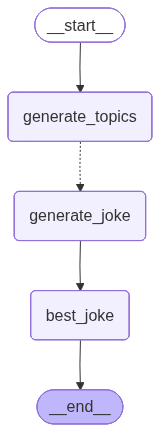

In [9]:
# 导入 IPython.display 的 Image，用于显示图像
from IPython.display import Image

# 从 langgraph.graph 导入 END、StateGraph、START
# StateGraph：用于构建状态驱动的图
# START/END：表示图的起点和终点
from langgraph.graph import END, StateGraph, START


# 构建整个图：把前面定义的节点和逻辑组合在一起
graph = StateGraph(OverallState)  # 使用 OverallState 作为图的状态结构

# 添加节点：生成子主题
graph.add_node("generate_topics", generate_topics)

# 添加节点：根据子主题生成笑话
graph.add_node("generate_joke", generate_joke)

# 添加节点：选择最佳笑话
graph.add_node("best_joke", best_joke)

# 添加边：从 START 到 generate_topics
graph.add_edge(START, "generate_topics")

# 添加条件边：从 generate_topics 到 generate_joke
# continue_to_jokes 决定如何将每个子主题发送给 generate_joke
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])

# 添加边：从 generate_joke 到 best_joke
graph.add_edge("generate_joke", "best_joke")

# 添加边：从 best_joke 到 END
graph.add_edge("best_joke", END)


# 编译图，得到可运行的应用对象
app = graph.compile()

# 将图结构绘制成 mermaid 格式的 PNG 图片并显示
Image(app.get_graph().draw_mermaid_png())


In [10]:
# 调用图：这里我们传入一个主题 "animals"，让图生成一组笑话
for s in app.stream({"topic": "animals"}):
    # 打印流式输出的每个状态更新（每一步节点的执行结果都会被依次返回）
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior and Communication', 'Conservation and Endangered Species', 'Animal Habitats and Ecosystems']}}
{'generate_joke': {'jokes': ['Why did the endangered species start a band?\n\nBecause they wanted to make some "wild" music and get on the "endangered" charts before they went extinct!']}}
{'generate_joke': {'jokes': ['Why did the squirrel bring a suitcase to the forest?\n\nBecause it heard the ecosystem was "tree-mendous" and wanted to branch out!']}}
{'generate_joke': {'jokes': ['Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!']}}
{'best_joke': {'best_selected_joke': 'Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!'}}


In [11]:
# END